# Prepping data

In [1]:
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
#import h5netcdf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from glob import glob
import seaborn as sns

import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/home/laurapong321/leap_24/les_sim_2'

#getting the correct dimension values
nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]
#rewrite this code but using 'Ug2Q010_IV.nc' instead
nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    #reading in the data for each group
    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")


    #assigning the correct dims
    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})
    
    return ds

In [4]:
def find_jump(ds, filter_num=.001):
    """
    Returns a dataset with the new variable
    del_th_sd, del_sft, del_eft with only the time coordinate
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])
    sft_jump = np.array([])
    eft_jump = np.array([])

    #prepping ds
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th", "eft", "sft"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        

        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump_th = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        jump_sft = (ds_jump.isel(time=i, z=max_z).sft.values - ds_jump.isel(time=i, z=min_z).sft.values)
        jump_eft = (ds_jump.isel(time=i, z=max_z).eft.values - ds_jump.isel(time=i, z=min_z).eft.values)

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump_th])
            sft_jump = np.array([jump_sft])
            eft_jump = np.array([jump_eft])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump_th])))
            sft_jump = np.concatenate((sft_jump, np.array([jump_sft])))
            eft_jump = np.concatenate((eft_jump, np.array([jump_eft])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))
    ds = ds.assign(del_sft_sd=(["time"], sft_jump))
    ds = ds.assign(del_eft_sd=(["time"], eft_jump))


    return ds
    

In [40]:
def prep_ds(ds, ug, q, filter_num_sd=.001):
    """
    Makes an xarray dataset with all the necesscary variables for
    equation discovery"""

    ds_return = ds.copy()
    #selecting necessary vars
    ds_return = ds_return[["zi", "th", "th_flux", "b_flux",
                        "sft", "sft_flux", "eft", "eft_flux"]]

    #calc dh/dt
    dt = ds_return.time.isel(time=1).values - ds_return.time.isel(time=0).values
    bl_evo = np.gradient(ds_return.zi, int(dt))
    #adding dh/dt to ds
    ds_return = ds_return.assign(dh_dt=(['time'],bl_evo))

    #finding del_th
    ds_return = find_jump(ds_return, filter_num_sd)

    #new method for del_eft
    ds_return["del_eft_new"] = 1 - ds_return.eft.isel(z=slice(50, 90)).mean("z")
    
    #making surface b_flux
    ds_return["b_flux_sfc"] = ds_return.b_flux.sel(zh=0)

    #making u_g var
    u_g = ug*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(u_g=(["time"], u_g))

    #making q var
    q = q*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(q=(["time"], q))

    #surface th flux
    ds_return["th_flux_sfc"] = ds_return.th_flux.isel(zh=0)

    #finding th_flux min
    ds_return["th_flux_min"] = ds_return.th_flux.min(dim="zh")

    #finding h_minus
    ds_return["h_minus"] = xr.where(ds_return["th_flux_min"],
                                     ds_return.isel(zh=ds_return.th_flux.argmin(dim="zh")).zh, 
                                     np.nan)
    
    #finding flux of sft at h_minus
    ds_return["sft_flux_min"] = ds_return.sft_flux.min(dim="zh")
    
    #finding flux of eft at h_minus
    ds_return["eft_flux_min"] = ds_return.eft_flux.min(dim="zh")

    #finding eft flux sfc
    ds_return["eft_flux_sfc"] = ds_return.eft_flux.isel(zh=0)

    #finding surface eft
    ds_return["eft_sfc"] = ds_return.eft.isel(z=0)


    #finding we from the discovered equation
    ds_return["we"] = 9.961432*ds_return["b_flux_sfc"]/ds_return["del_th_sd"] + 0.0009702546*ds_return["u_g"]

    #finding h deft/dt
    eft_evo = np.gradient(ds_return.isel(z=75).eft, int(dt))
    eft_evo_avg = np.gradient(ds_return.isel(z=slice(50, 90)).eft.mean("z"), int(dt))
    ds_return = ds_return.assign(deft_dt=(['time'],eft_evo))
    ds_return = ds_return.assign(deft_dt_avg=(['time'],eft_evo_avg))
    ds_return["h_deft_dt"] = ds_return.zi * ds_return.deft_dt
    ds_return["h_deft_dt_avg"] = ds_return.zi * ds_return.deft_dt_avg


    #calc we*del_eft from assumption
    ds_return["we_del_eft"] = ds_return["we"]*ds_return["del_eft_sd"]

    #resampling using coarsen across all variables
    ds_return = ds_return.coarsen(time=15).mean()
    
    return ds_return
    

In [6]:
#opening data
folder_path = '/home/laurapong321/leap_24/les_sim_2'

files = glob(f"{folder_path}/*")

iv16_1 = read_data(files[1])
iv16_3 = read_data(files[2])
i16_6 = read_data(files[3])
iv16_6 = read_data(files[4])
iv16_10 = read_data(files[5])
ii10_1 = read_data(files[6])
i2_10 = read_data(files[7])
iv2_10 = read_data(files[8])
iii2_1 = read_data(files[9])
i2_24 = read_data(files[10])
iii8_3 = read_data(files[11])
ii8_3 = read_data(files[12])
iv8_3 = read_data(files[13])
iv8_6 = read_data(files[14])

In [7]:
files

['/home/laurapong321/leap_24/les_sim_2/Ug16Q000_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug16Q001_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug16Q003_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug16Q006_I.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug16Q006_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug16Q010_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug1Q01_II.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug2Q010_I.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug2Q010_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug2Q01_III.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug2Q024_I.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug8Q003_III.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug8Q003_II.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug8Q003_IV.nc',
 '/home/laurapong321/leap_24/les_sim_2/Ug8Q006_IV.nc']

In [41]:
#prepping all the simulations for sr
iv16_1_ed = prep_ds(iv16_1, 16, 1, filter_num_sd=.001)
iv16_3_ed = prep_ds(iv16_3, 16, 3, filter_num_sd=.00075)
i16_6_ed = prep_ds(i16_6, 16, 6, filter_num_sd=.0002)
iv16_6_ed = prep_ds(iv16_6, 16, 6)
iv16_10_ed = prep_ds(iv16_10, 16, 10)
ii10_1_ed = prep_ds(ii10_1, 10, 1)
i2_10_ed = prep_ds(i2_10, 2, 10, filter_num_sd=.00025)
iv2_10_ed = prep_ds(iv2_10, 2, 10)
iii2_1_ed = prep_ds(iii2_1, 2, 1)
i2_24_ed = prep_ds(i2_24, 2, 24, filter_num_sd=.002)
iii8_3_ed = prep_ds(iii8_3, 8, 3)
ii8_3_ed = prep_ds(ii8_3, 8, 3)
iv8_3_ed = prep_ds(iv8_3, 8, 3)
iv8_6_ed = prep_ds(iv8_6, 8, 6)

### Verifying if discovered $w_e$ is good and looking for the existance of eft overshoot

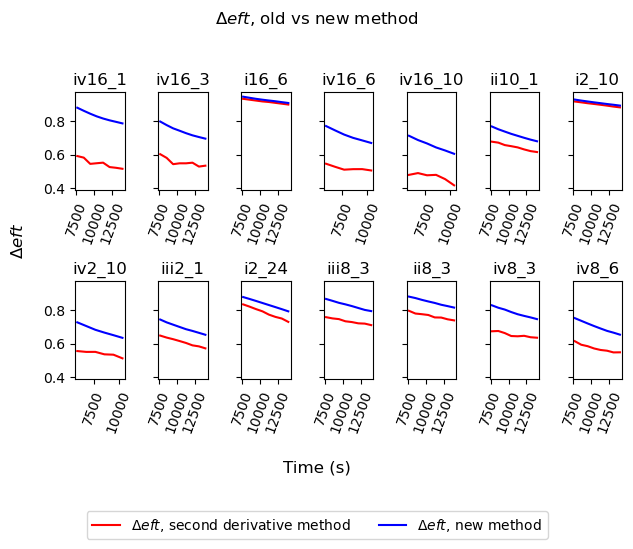

In [9]:
sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_10", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("$\\Delta eft$, old vs new method")
fig.supxlabel("Time (s)")
fig.supylabel("$\\Delta eft$")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$\\Delta eft$, second derivative method", 
                 "$\\Delta eft$, new method"]
colors = ["r", "b"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, (sim_list[i].del_eft_sd), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, (1 - sim_list[i].isel(z=slice(50,90)).eft.mean("z")), color=colors[1], label=legend_labels[1])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()


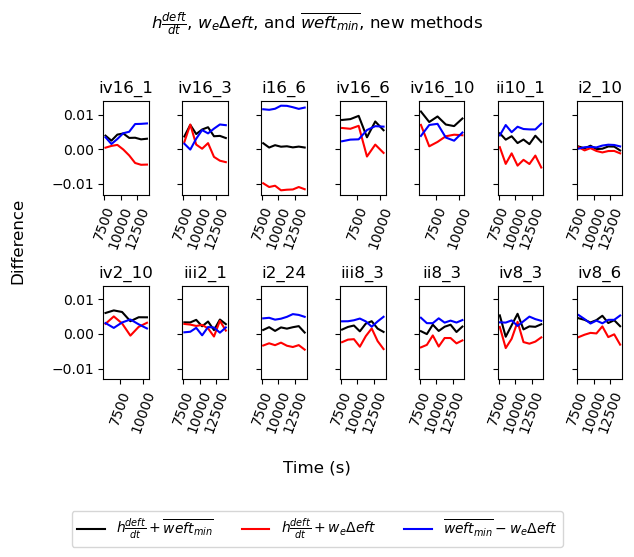

In [10]:
sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_10", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("$h\\frac{{deft}}{{dt}}$, $w_e\\Delta eft$, and $\\overline{w eft_{min}}$, new methods")
fig.supxlabel("Time (s)")
fig.supylabel("Difference")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$h\\frac{{deft}}{{dt}} + \\overline{w eft_{min}}$", 
                 "$h\\frac{{deft}}{{dt}} + w_e\\Delta eft$", 
                 "$\\overline{w eft_{min}} - w_e\\Delta eft$"]
colors = ["k", "r", "b"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, (sim_list[i].h_deft_dt_avg + sim_list[i].eft_flux_min), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].h_deft_dt_avg - (sim_list[i].we * sim_list[i].del_eft_new)), color=colors[1], label=legend_labels[1])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min + (sim_list[i].we * sim_list[i].del_eft_new)), color=colors[2], label=legend_labels[2])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()


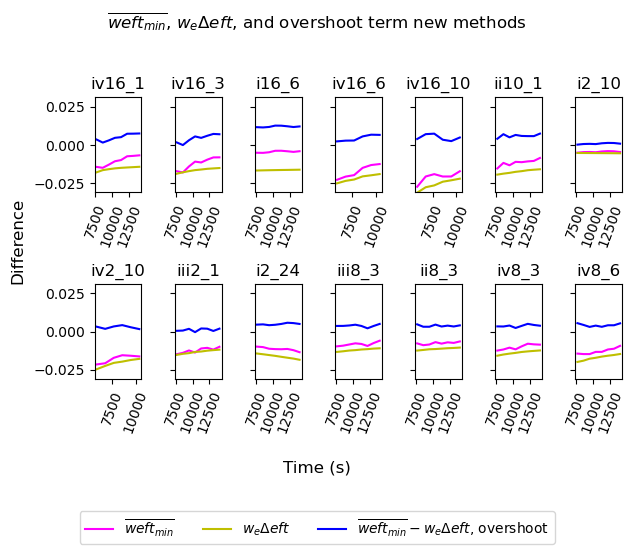

In [11]:
### LOOKING FOR AN OVERSHOOT TERM (BLUE) ###


sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_10", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("$\\overline{w eft_{min}}$, $w_e\\Delta eft$, and overshoot term new methods")
fig.supxlabel("Time (s)")
fig.supylabel("Difference")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$\\overline{w eft_{min}}$", 
                 "$w_e\\Delta eft$", 
                 "$\\overline{w eft_{min}} - w_e\\Delta eft$, overshoot"]
colors = ["magenta", "y", "b"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, (-1*(sim_list[i].we * sim_list[i].del_eft_new)), color=colors[1], label=legend_labels[1])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min + (sim_list[i].we * sim_list[i].del_eft_new)), color=colors[2], label=legend_labels[2])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ylim(-.031, .031)

# Show plot
plt.show()


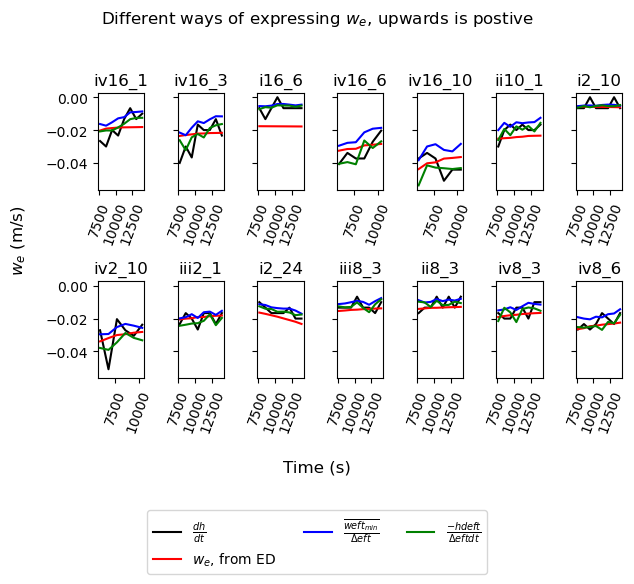

In [12]:
### VERIFYING THE DISCOVERED We ###


sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]

sim_list_str = ["iv16_1", "iv16_3", "i16_6",
                "iv16_6", "iv16_10", "ii10_1",
                "i2_10", "iv2_10", "iii2_1",
                "i2_24", "iii8_3", "ii8_3", 
                "iv8_3", "iv8_6"]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, sharey=True)#, figsize=(20, 10))

fig.suptitle("Different ways of expressing $w_e$, upwards is postive")
fig.supxlabel("Time (s)")
fig.supylabel("$w_e$ (m/s)")

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7,
           ax8, ax9, ax10, ax11, ax12, ax13, ax14]

# Define legend labels and colors
legend_labels = ["$\\frac{{{dh}}}{{{dt}}}$", 
                 "$w_e$, from ED", 
                 "$\\frac{{{\\overline{w eft_{min}}}}}{{{\\Delta eft}}}$",
                 "$\\frac{{{-h deft}}}{{{\\Delta eft dt}}}$"]
colors = ["k", "r", "b", "g"]

for i in range(len(sim_list)):
    ax_list[i].plot(sim_list[i].time, -1*(sim_list[i].dh_dt), color=colors[0], label=legend_labels[0])
    ax_list[i].plot(sim_list[i].time, -1*(sim_list[i].we), color=colors[1], label=legend_labels[1])
    ax_list[i].plot(sim_list[i].time, (sim_list[i].eft_flux_min / sim_list[i].del_eft_new), color=colors[2], label=legend_labels[2])
    ax_list[i].plot(sim_list[i].time, (-1*sim_list[i].h_deft_dt_avg / sim_list[i].del_eft_new), color=colors[3], label=legend_labels[3])
    ax_list[i].set_title(sim_list_str[i])
    ax_list[i].tick_params(axis='x', labelrotation=70)

# Add a single legend for the entire figure
handles, labels = ax_list[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()


I changed the method of finding the eft in the mixed layer and finding delta_eft in the way we talked about in meeting. The del_eft changed a bit in magnitude, but its time evoltion had the same shape as before (***INSERT PLOT HERE***). I did the same type of graph for the different ways of representing the overshoot, whith the new eft variables, and this new graph looks the same: the black line still inidcates no overshoot while the blue line does (***INSERT PLOT HERE***). I then graphed all the ways of reprenting w_e through time: dh/dt (which was what I used as my truth from the equation discovery), the w_e from the equation discovery, eft_flux_min / del_eft, and (-h / del_eft)*(deft/dt). Plotting all of these, there is a clear separation between the dh/dt and w_e lines and the eft_flux_min / del_eft, and (-h / del_eft)*(deft/dt) lines. I think that this indicates that an overshoot term is missing, because the blue and green lines are consistently lower magnitude than the black and red lines.

Another aside, I noticed that in the w_e graph, the red and black lines seemed to just be reflections of the blue and green lines across the x-axis. I plotted the absolute values of all the lines and saw that all the different ways of calulating w_e seemed to match pretty closly (***INSERT PLOT HERE***). I don't know if this means that there is something wrong with my dh/dt and w_e from ED, or if there is something going on with the green and blue lines. The equation from equation discovery was: 9.961432*b_flux / del_th_sd + 0.0009702546*u_g. If we take 9.961432 to be A / (g / theta_0), I get that A = 0.3257388264.

Here are my questions:

1. should w_e be negative or postive? It seems that the blue and green lines, using the equations from the notes, indicates that w_e should negative, but the dh_dt and the w_e from ED indicates that w_e is postive. To find dh_dt, I did np.gradient(ds.zi, dt), where dt=60s.
2. I'm not sure what to make of the second graph, where the black line indicates no overshoot, whereas the blue line indicates the presence of one. Should I try to run an equation discovery model anway, using the blue line as truth?
3. Taking the absolute values of all the w_e made me wonder what adding the terms of the blue line in the second graph would do (plotting eft_flux_min + w_e * del_eft instead of eft_flux_min - w_e * del_eft). Plotting, I saw that the blue and black lines are both close to 0. I was wondering if this new blue line make phyical sense, and if both blue and black lines indicate that there is no overshoot.

# Equation discovery for overshoot

In [16]:
def extract_var(var):
    """
    Returns a 1d array of the desired variable across all simulations
    """

    #making a list of all the simulations to loop through
    sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_10_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]
    
    #making empty array to putt all the data in
    var_arr = np.array([])

    #making a 1d array of the var from the simulation
    for sim in sim_list:
        sim_var = sim[var].to_numpy()
        
        #adding to the var_arr
        if len(var_arr) == 0:
            var_arr = sim_var
        else:
            var_arr = np.concatenate((var_arr, sim_var))
    
    return var_arr


In [39]:
iv16_1_ed

<xarray.Dataset>
Dimensions:        (time: 8, z: 384, zh: 385)
Coordinates:
  * time           (time) float64 7.68e+03 8.58e+03 ... 1.308e+04 1.398e+04
  * z              (z) float64 3.0 9.0 15.0 ... 2.289e+03 2.295e+03 2.301e+03
  * zh             (zh) float64 0.0 6.0 12.0 ... 2.292e+03 2.298e+03 2.304e+03
Data variables: (12/28)
    zi             (time) float64 880.6 910.2 935.0 ... 978.6 992.6 1.002e+03
    th             (time, z) float64 300.2 300.2 300.2 ... 307.9 308.0 308.0
    th_flux        (time, zh) float64 0.01 0.009874 0.00975 ... -1.833e-05 0.0
    b_flux         (time, zh) float64 0.000327 0.0003162 ... -5.39e-08 0.0
    sft            (time, z) float64 2.192 2.022 1.912 ... 1.576e-53 4.888e-55
    sft_flux       (time, zh) float64 0.1 0.09928 0.09858 ... 1.106e-56 0.0
    ...             ...
    we             (time) float64 0.02029 0.0191 0.01876 ... 0.01823 0.01816
    deft_dt        (time) float64 2.133e-05 1.817e-05 ... 9.986e-06 1.025e-05
    deft_dt_avg    (time) float64 2.077e-05 1.913e-05 ... 1.009e-05 9.83e-06
    h_deft_dt      (time) float64 0.0188 0.01655 0.01702 ... 0.009913 0.01027
    h_deft_dt_avg  (time) float64 0.01831 0.01742 0.0171 ... 0.01002 0.009848
    we_del_eft     (time) float64 0.01192 0.01111 0.01021 ... 0.009493 0.009348

In [42]:
#solving for overshoot term, putting we in the correct coordinate system
we = extract_var("we")
del_eft = extract_var("del_eft_new")
eft_sfc = extract_var("eft_sfc")
eft_flux_min = extract_var("eft_flux_min")
eft_flux_sfc = extract_var("eft_flux_sfc")
we_del_eft = -1* we * del_eft
th_flux_sfc = extract_var("th_flux_sfc")
del_th_sd = extract_var("del_th_sd")
q = extract_var("q")
u_g = extract_var("u_g")

overshoot = eft_flux_min - we_del_eft

In [43]:
#making x and y for ed

X = pd.DataFrame(np.column_stack([we, del_eft, eft_sfc,
                                  th_flux_sfc, del_th_sd,
                                  eft_flux_sfc, q, u_g]),
                columns=["we", "del_eft", "eft_sfc",
                         "th_flux_sfc", "del_th_sd",
                         "eft_flux_sfc", "q", "u_g"])

y = overshoot.copy()

In [48]:
#bulding model
eft_overshoot_model = PySRRegressor(
    niterations=5000,  # < Increase for better results
    batching=True, #same as minibatching for NN
    batch_size=50,

    binary_operators=["+", "-", "*", "/"],
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [49]:
eft_overshoot_model.fit(X, y)

/home/laurapong321/anaconda3/envs/pnw_env/lib/python3.12/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.320e+05
Head worker occupation: 10.1%
Progress: 317 / 75000 total iterations (0.423%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.991e-02  1.594e+01  y = eft_sfc
3           6.494e-06  4.473e+00  y = u_g * 0.00043175
5           4.550e-06  1.779e-01  y = 0.00033362 * (del_th_sd + u_g)
7           4.432e-06  1.309e-02  y = ((u_g + del_th_sd) * 0.00033362) * 1.0508
9           4.109e-06  3.794e-02  y = (0.063708 * ((we * del_th_sd) + we)) + eft_flux_sfc
13          2.994e-06  7.914e-02  y = (((0.29904 / (0.9511 + (del_th_sd / u_g))) * we) * 0.42237...
                                  ) * del_th_sd
15          2.981e-06  2.095e-03  y = (((0.29904 / (0.9511 + (del_th_sd / u_g))) * we) * 0.42237...
                                  ) * (del_th_sd - th_flux_sfc)
17          2.959e-06  3.665e-03  y = (((0.29904 / (0.9511 + ((del_th

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       0.0043990985   
	1        0.114714                                0.00042764103 * u_g   
	2        0.193322                   (del_th_sd + u_g) * 0.0003617995   
	3        0.139836     0.0035182172 + ((del_th_sd * 6.1592e-5) * u_g)   
	4  >>>>  0.112739  (u_g * ((0.0036795435 * del_th_sd) * we)) + 0....   
	5        0.029274  0.0030991877 + ((((u_g * we) - 0.05317303) * d...   
	6        0.101381  del_th_sd * ((u_g * 0.000103729166) - (-0.0020...   
	7        0.002628  (del_th_sd + we) * ((u_g * 0.000103729166) - (...   
	8        0.011417  (del_th_sd * (((u_g / del_eft) * 0.00010372916...   
	9        0.000053  (del_th_sd * ((((u_g + th_flux_sfc) / del_eft)...   
	
	       loss  complexity  
	0  0.000008           1  
	1  0.000006           3  
	2  0.000004           5  
	3  0.000003           7  
	4  0.000003           9  
	5  0.000003          11  
	6  0.000002          13  
	7  0.000002          15  
	8  0.000002          17  
	9  0.000002          19  
]

In [50]:
eft_overshoot_model.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.000008,0.000000,0.0043990985,0.00439909850000000,PySRFunction(X=>0.00439909850000000)
1,3,0.000006,0.114714,0.00042764103 * u_g,0.00042764103*u_g,PySRFunction(X=>0.00042764103*u_g)
2,5,0.000004,0.193322,(del_th_sd + u_g) * 0.0003617995,0.0003617995*del_th_sd + 0.0003617995*u_g,PySRFunction(X=>0.0003617995*del_th_sd + 0.000...
3,7,0.000003,0.139836,0.0035182172 + ((del_th_sd * 6.1592e-5) * u_g),6.1592e-5*del_th_sd*u_g + 0.0035182172,PySRFunction(X=>6.1592e-5*del_th_sd*u_g + 0.00...
4,9,0.000003,0.112739,(u_g * ((0.0036795435 * del_th_sd) * we)) + 0....,0.0036795435*del_th_sd*u_g*we + 0.0025949404,PySRFunction(X=>0.0036795435*del_th_sd*u_g*we ...
5,11,0.000003,0.029274,0.0030991877 + ((((u_g * we) - 0.05317303) * d...,0.004301789*del_th_sd*(u_g*we - 0.05317303) + ...,PySRFunction(X=>0.004301789*del_th_sd*(u_g*we ...
6,13,0.000002,0.101381,del_th_sd * ((u_g * 0.000103729166) - (-0.0020...,del_th_sd*(-0.000270480000000017*del_th_sd + 0...,PySRFunction(X=>del_th_sd*(-0.0002704800000000...
7,15,0.000002,0.002628,(del_th_sd + we) * ((u_g * 0.000103729166) - (...,(del_th_sd + we)*(-0.000270480000000017*del_th...,PySRFunction(X=>(del_th_sd + we)*(-0.000270480...
8,17,0.000002,0.011417,(del_th_sd * (((u_g / del_eft) * 0.00010372916...,0.90010387*del_th_sd*(-0.000270480000000017*de...,PySRFunction(X=>0.90010387*del_th_sd*(-0.00027...
9,19,0.000002,0.000053,(del_th_sd * ((((u_g + th_flux_sfc) / del_eft)...,0.90010387*del_th_sd*(-0.000270480000000017*de...,PySRFunction(X=>0.90010387*del_th_sd*(-0.00027...


In [53]:
eft_overshoot_model.equations_.iloc[4, 4]

0.0036795435*del_th_sd*u_g*we + 0.0025949404

In [33]:
eft_overshoot_model.equations_.iloc[-2, 4]

0.00455641537650062

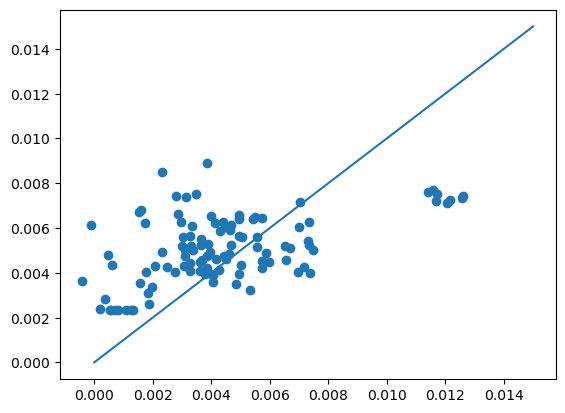

In [37]:
plt.scatter(y, (0.0054464745*del_eft - 0.5084563))
plt.plot([0, .015], [0, .015])